# ID5059 Group Project - Gradient Boosting Model for Temperature Prediction
##  This notebook implements a Gradient Boosting model to predict temperature (t2m) from weather data.


## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Importing necessary librarie
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

# For modeling
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

## 2. Load Data

In [2]:
# Function to load data from file with sampling
def loadData(fileName, filePath="./", delimiter=",", sample_size=None, random_state=1):
    path = Path(filePath) / fileName
    if not path.is_file():
        raise Exception(f"File not found: {path}")
    
    if sample_size is not None:
        # Load only a sample of the data
        # First count total lines to determine skiprows
        total_rows = sum(1 for _ in open(path)) - 1  # Subtract 1 for header
        
        if sample_size >= total_rows:
            return pd.read_csv(path, sep=delimiter)
        
        # Generate random row indices to sample
        np.random.seed(random_state)
        skip_indices = sorted(np.random.choice(
            range(1, total_rows + 1), 
            size=total_rows - sample_size, 
            replace=False
        ))
        
        # Always include header (row 0)
        return pd.read_csv(path, sep=delimiter, skiprows=skip_indices)
    else:
        # Load the entire dataset
        return pd.read_csv(path, sep=delimiter)

# Function to convert datetime components
def convertDateTimeToComponents(data, column):
    data["year"] = data[column].dt.year
    data["month"] = data[column].dt.month
    data["day"] = data[column].dt.day
    data["hour"] = data[column].dt.hour
    data["season"] = ((data["month"] % 12 + 3) // 3)  # Winter: 1, Spring: 2, Summer: 3, Fall: 4
    return data

# Function to prepare data (drop id, convert time, extract components)
def prepareData(data, keep_valid_time=False):
    # Make a copy to avoid modifying the original
    data = data.copy()
    
    # Drop ID column
    data.drop(["id"], axis=1, inplace=True)
    
    # Convert valid_time to datetime
    data["valid_time"] = pd.to_datetime(data["valid_time"])
    
    # Extract datetime components
    data = convertDateTimeToComponents(data, "valid_time")
    
    # Optionally keep valid_time (needed for test predictions)
    if not keep_valid_time:
        data.drop(["valid_time"], axis=1, inplace=True)
    
    return data

### 3.1 Preprocessing

In [3]:
# Load a sample of the training data
filePath = "./"
sample_size_train = 100000  # Number of rows to sample
dataTrain = loadData("train.csv", filePath, sample_size=sample_size_train, random_state=RANDOM_SEED)


# Load test data (no need to sample)
sample_size_test = 100000  # Number of rows to sample
dataTest = loadData("test.csv", filePath, sample_size=sample_size_test, random_state=RANDOM_SEED)

# Preprocess both datasets
dataTrain = prepareData(dataTrain)
dataTest = prepareData(dataTest, keep_valid_time=True)  # Keep valid_time for predictions

# Save valid_time from test data before dropping
test_valid_time = dataTest['valid_time'].copy()
if 'valid_time' in dataTest.columns:
    dataTest.drop(["valid_time"], axis=1, inplace=True)

# Display shapes after preprocessing
print(f"Training data shape: {dataTrain.shape}")
print(f"Test data shape: {dataTest.shape}")

Training data shape: (100000, 16)
Test data shape: (100000, 15)


In [4]:
# Define categorical and numerical attributes
attributes = list(dataTrain.columns)
one_hot_attributes = ["year", "month", "day", "hour", "season", "ptype"]
numerical_attributes = list(filter(lambda item: item not in one_hot_attributes + ["t2m"], attributes))

print("Categorical attributes for one-hot encoding:", one_hot_attributes)
print("Numerical attributes for scaling:", numerical_attributes)

# Create comprehensive weather features
def engineer_weather_features(df):
    """Create derived weather features that might help prediction"""
    print("Engineering weather features...")
    result_df = df.copy()
    
    # Wind features
    result_df['wind_speed_10m'] = np.sqrt(result_df['u10']**2 + result_df['v10']**2)
    result_df['wind_speed_100m'] = np.sqrt(result_df['u100']**2 + result_df['v100']**2)
    result_df['wind_shear'] = result_df['wind_speed_100m'] - result_df['wind_speed_10m']
    
    # Wind direction (in degrees, 0-360)
    result_df['wind_direction_10m'] = (np.arctan2(result_df['v10'], result_df['u10']) * 180 / np.pi) % 360
    
    # Pressure-temperature interaction (related to air mass characteristics)
    # Can't use t2m for test data, so we skip this derived feature
    
    # Cloud-based features
    result_df['cloud_impact'] = result_df['tcc'] * 10  # Scale up impact of cloud cover
    
    # Calculate day of year (for seasonal effects)
    result_df['day_of_year'] = (result_df['month'].astype(int) - 1) * 30 + result_df['day'].astype(int)
    
    # Calculate solar angle approximation 
    # (rough proxy for solar radiation, which strongly affects temperature)
    hour_rad = (result_df['hour'] - 12) * np.pi / 12
    day_of_year_norm = (result_df['day_of_year'] - 183) / 183 * np.pi  # normalize to [-π, π]
    
    # Solar angle depends on latitude, time of day, and day of year
    result_df['solar_angle'] = np.cos(hour_rad) * np.cos(day_of_year_norm) * \
                             np.cos(np.radians(result_df['latitude'] - 55))  # centered around UK
    
    print(f"Added {len(result_df.columns) - len(df.columns)} basic weather features")
    return result_df

# Create spatially nearby features with improved implementation
def add_nearby_features(df, radius=0.25):
    """
    Add features from nearby locations to help with prediction.
    - radius: Search radius in degrees (approximately 25 km)
    """
    print("Adding nearby spatial features...")
    result_df = df.copy()
    
    # Features to create spatial aggregations for - expanded set
    key_features = ['sp', 'tp', 'tcc', 'u10', 'v10', 'wind_speed_10m', 'wind_speed_100m', 'solar_angle']
    
    # Create empty columns for spatial features
    for feat in key_features:
        if feat in result_df.columns:  # Make sure feature exists
            result_df[f'{feat}_nearby_mean'] = np.nan
            result_df[f'{feat}_nearby_min'] = np.nan
            result_df[f'{feat}_nearby_max'] = np.nan
    
    # Process in batches by time to improve performance
    time_groups = result_df.groupby(['year', 'month', 'day', 'hour'])
    
    print(f"Processing {len(time_groups)} time groups for spatial features...")
    group_count = 0
    
    for time_key, group in time_groups:
        group_count += 1
        if group_count % 10 == 0:
            print(f"Processed {group_count}/{len(time_groups)} time groups...")
        
        # Use vectorized operations where possible
        for idx, row in group.iterrows():
            # Calculate distances for all points in this time group
            lat_diffs = np.abs(group['latitude'] - row['latitude'])
            lon_diffs = np.abs(group['longitude'] - row['longitude'])
            
            # Find nearby points (within radius but not the same point)
            nearby_mask = (lat_diffs <= radius) & (lon_diffs <= radius) & \
                          ((lat_diffs > 0) | (lon_diffs > 0))
            
            nearby = group[nearby_mask]
            
            # Skip if no nearby points found
            if len(nearby) == 0:
                continue
                
            # Calculate and store statistics for nearby points
            for feat in key_features:
                if feat in result_df.columns:
                    result_df.loc[idx, f'{feat}_nearby_mean'] = nearby[feat].mean()
                    result_df.loc[idx, f'{feat}_nearby_min'] = nearby[feat].min()
                    result_df.loc[idx, f'{feat}_nearby_max'] = nearby[feat].max()
    
    # Fill any missing values (points with no neighbors)
    for feat in key_features:
        if feat in result_df.columns:
            # Fill missing values with the original feature value
            result_df[f'{feat}_nearby_mean'].fillna(result_df[feat], inplace=True)
            result_df[f'{feat}_nearby_min'].fillna(result_df[feat], inplace=True)
            result_df[f'{feat}_nearby_max'].fillna(result_df[feat], inplace=True)
    
    # Add temperature gradient features based on latitude/longitude
    if 't2m' in result_df.columns:  # Only for training data
        print("Calculating temperature gradients...")
        
        # Create empty gradient columns
        result_df['temp_lat_gradient'] = np.nan
        result_df['temp_lon_gradient'] = np.nan
        
        # Process latitude gradients
        for _, group in result_df.groupby(['year', 'month', 'day', 'hour', 'longitude']):
            if len(group) > 1:
                # Sort by latitude
                group = group.sort_values('latitude')
                
                # Calculate gradients between adjacent points
                lats = group['latitude'].values
                temps = group['t2m'].values
                
                # Calculate gradients for each adjacent pair
                for i in range(len(group)-1):
                    lat_diff = lats[i+1] - lats[i]
                    temp_diff = temps[i+1] - temps[i]
                    gradient = temp_diff / lat_diff if lat_diff != 0 else 0
                    
                    # Assign to both points (simplified approach)
                    result_df.loc[group.index[i:i+2], 'temp_lat_gradient'] = gradient
        
        # Process longitude gradients
        for _, group in result_df.groupby(['year', 'month', 'day', 'hour', 'latitude']):
            if len(group) > 1:
                # Sort by longitude
                group = group.sort_values('longitude')
                
                # Calculate gradients between adjacent points
                lons = group['longitude'].values
                temps = group['t2m'].values
                
                # Calculate gradients for each adjacent pair
                for i in range(len(group)-1):
                    lon_diff = lons[i+1] - lons[i]
                    temp_diff = temps[i+1] - temps[i]
                    gradient = temp_diff / lon_diff if lon_diff != 0 else 0
                    
                    # Assign to both points
                    result_df.loc[group.index[i:i+2], 'temp_lon_gradient'] = gradient
    
    # Fill missing gradient values with zeros
    if 'temp_lat_gradient' in result_df.columns:
        result_df['temp_lat_gradient'].fillna(0, inplace=True)
    if 'temp_lon_gradient' in result_df.columns:
        result_df['temp_lon_gradient'].fillna(0, inplace=True)
    
    # Count only newly added columns
    added_cols = [col for col in result_df.columns if col not in df.columns]
    print(f"Added {len(added_cols)} new nearby features")
    
    return result_df

# Add temporal features
def add_temporal_features(df):
    """
    Add features from previous time periods to capture temporal patterns
    """
    print("Adding temporal features...")
    result_df = df.copy()
    
    # Features to create temporal lags for
    lag_features = ['sp', 'tp', 'tcc', 'u10', 'v10', 'wind_speed_10m']
    
    # Group by location to process time series for each point
    location_groups = result_df.groupby(['latitude', 'longitude'])
    
    # Progress tracking
    total_groups = len(location_groups)
    print(f"Processing {total_groups} locations for temporal features...")
    group_count = 0
    
    # Process each location group
    for _, group in location_groups:
        group_count += 1
        if group_count % 100 == 0:
            print(f"Processed {group_count}/{total_groups} locations...")
            
        # Sort by time components
        sorted_group = group.sort_values(['year', 'month', 'day', 'hour'])
        
        if len(sorted_group) <= 1:
            continue
            
        # Get indices in original order
        indices = sorted_group.index
        
        # Create lag features (previous time steps)
        for feat in lag_features:
            if feat in result_df.columns:
                # Previous hour (lag 1)
                values_prev1 = sorted_group[feat].shift(1)
                result_df.loc[indices, f'{feat}_lag1'] = values_prev1
                
                # Previous 3 hours (lag 3)
                values_prev3 = sorted_group[feat].shift(3)
                result_df.loc[indices, f'{feat}_lag3'] = values_prev3
                
                # Calculate rate of change (first derivative)
                if len(sorted_group) >= 2:
                    values_diff = sorted_group[feat].diff(1)
                    result_df.loc[indices, f'{feat}_change'] = values_diff
    
    # Fill missing values for lag features
    for feat in lag_features:
        if feat in result_df.columns:
            # Fill lag values with the current value (no history effect)
            result_df[f'{feat}_lag1'].fillna(result_df[feat], inplace=True)
            result_df[f'{feat}_lag3'].fillna(result_df[feat], inplace=True)
            
            # Fill change values with zero (no change)
            result_df[f'{feat}_change'].fillna(0, inplace=True)
    
    # Count only newly added columns
    added_cols = [col for col in result_df.columns if col not in df.columns]
    print(f"Added {len(added_cols)} temporal features")
    
    return result_df

# Calculate temperature-specific interaction features
def add_temperature_interactions(df):
    """
    Add features that interact with temperature or are known to affect it
    Based on meteorological relationships
    """
    print("Adding temperature interaction features...")
    result_df = df.copy()
    
    # Create day-night indicator (rough approximation)
    result_df['is_daytime'] = ((result_df['hour'] >= 6) & (result_df['hour'] <= 18)).astype(int)
    
    # Latitude adjustment for temperature expectations
    result_df['latitude_temp_factor'] = (55 - result_df['latitude']).abs() * 0.5
    
    # Coastal proximity approximation (rough, based on UK geography)
    is_coastal_longitude = ((result_df['longitude'] > -8) & (result_df['longitude'] < -5)) | \
                          ((result_df['longitude'] > 1))
    is_coastal_latitude = ((result_df['latitude'] < 51.5)) | \
                         ((result_df['latitude'] > 58))
    result_df['coastal_proximity'] = (is_coastal_longitude | is_coastal_latitude).astype(int)
    
    # Seasonal temperature modulation
    result_df['season_temp_mod'] = np.cos((result_df['day_of_year'] - 183) * 2 * np.pi / 365)
    
    # Diurnal temperature modulation (daily cycle)
    result_df['diurnal_temp_mod'] = np.cos((result_df['hour'] - 14) * 2 * np.pi / 24)
    
    # Wind chill factor approximation
    result_df['wind_chill_factor'] = 13.12 + 0.6215 * (-273.15 + 8) - 11.37 * \
                                   (result_df['wind_speed_10m'] ** 0.16) + \
                                   0.3965 * (-273.15 + 8) * (result_df['wind_speed_10m'] ** 0.16)
    
    # Count only newly added columns
    added_cols = [col for col in result_df.columns if col not in df.columns]
    print(f"Added {len(added_cols)} temperature interaction features")
    
    return result_df

# Execute the complete feature engineering pipeline
print("\nStarting comprehensive feature engineering pipeline...")

# Step 1: Create basic weather features
print("\n--- Step 1: Basic Weather Features ---")
dataTrain = engineer_weather_features(dataTrain)
dataTest = engineer_weather_features(dataTest)

# Step 2: Add nearby spatial features
print("\n--- Step 2: Nearby Spatial Features ---")
dataTrain = add_nearby_features(dataTrain)
dataTest = add_nearby_features(dataTest)

# Step 3: Add temporal features 
print("\n--- Step 3: Temporal Features ---")
dataTrain = add_temporal_features(dataTrain)
dataTest = add_temporal_features(dataTest)

# Step 4: Add temperature interactions
print("\n--- Step 4: Temperature Interaction Features ---")
dataTrain = add_temperature_interactions(dataTrain)
dataTest = add_temperature_interactions(dataTest)

# Update numerical_attributes to include all the new features
numerical_attributes = [col for col in dataTrain.columns 
                       if col not in one_hot_attributes + ['t2m']]

print(f"\nFeature engineering complete. Total features: {len(numerical_attributes) + len(one_hot_attributes)}")
print(f"Numerical features: {len(numerical_attributes)}")
print(f"Categorical features: {len(one_hot_attributes)}")

Categorical attributes for one-hot encoding: ['year', 'month', 'day', 'hour', 'season', 'ptype']
Numerical attributes for scaling: ['latitude', 'longitude', 'tp', 'u10', 'v10', 'sp', 'u100', 'v100', 'tcc']

Starting comprehensive feature engineering pipeline...

--- Step 1: Basic Weather Features ---
Engineering weather features...
Added 7 basic weather features
Engineering weather features...
Added 7 basic weather features

--- Step 2: Nearby Spatial Features ---
Adding nearby spatial features...
Processing 8760 time groups for spatial features...
Processed 10/8760 time groups...
Processed 20/8760 time groups...
Processed 30/8760 time groups...
Processed 40/8760 time groups...
Processed 50/8760 time groups...
Processed 60/8760 time groups...
Processed 70/8760 time groups...
Processed 80/8760 time groups...
Processed 90/8760 time groups...
Processed 100/8760 time groups...
Processed 110/8760 time groups...
Processed 120/8760 time groups...
Processed 130/8760 time groups...
Processed 14

C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_15084\21262429.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df[f'{feat}_nearby_mean'].fillna(result_df[feat], inplace=True)
C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_15084\21262429.py:102: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

Calculating temperature gradients...


C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_15084\21262429.py:153: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df['temp_lat_gradient'].fillna(0, inplace=True)
C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_15084\21262429.py:155: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

Added 26 new nearby features
Adding nearby spatial features...
Processing 8760 time groups for spatial features...
Processed 10/8760 time groups...
Processed 20/8760 time groups...
Processed 30/8760 time groups...
Processed 40/8760 time groups...
Processed 50/8760 time groups...
Processed 60/8760 time groups...
Processed 70/8760 time groups...
Processed 80/8760 time groups...
Processed 90/8760 time groups...
Processed 100/8760 time groups...
Processed 110/8760 time groups...
Processed 120/8760 time groups...
Processed 130/8760 time groups...
Processed 140/8760 time groups...
Processed 150/8760 time groups...
Processed 160/8760 time groups...
Processed 170/8760 time groups...
Processed 180/8760 time groups...
Processed 190/8760 time groups...
Processed 200/8760 time groups...
Processed 210/8760 time groups...
Processed 220/8760 time groups...
Processed 230/8760 time groups...
Processed 240/8760 time groups...
Processed 250/8760 time groups...
Processed 260/8760 time groups...
Processed 

C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_15084\21262429.py:101: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df[f'{feat}_nearby_mean'].fillna(result_df[feat], inplace=True)
C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_15084\21262429.py:102: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

Processing 1517 locations for temporal features...
Processed 100/1517 locations...
Processed 200/1517 locations...
Processed 300/1517 locations...
Processed 400/1517 locations...
Processed 500/1517 locations...
Processed 600/1517 locations...
Processed 700/1517 locations...
Processed 800/1517 locations...
Processed 900/1517 locations...
Processed 1000/1517 locations...
Processed 1100/1517 locations...
Processed 1200/1517 locations...
Processed 1300/1517 locations...
Processed 1400/1517 locations...
Processed 1500/1517 locations...
Added 18 temporal features
Adding temporal features...


C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_15084\21262429.py:217: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df[f'{feat}_lag1'].fillna(result_df[feat], inplace=True)
C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_15084\21262429.py:218: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

Processing 1517 locations for temporal features...
Processed 100/1517 locations...
Processed 200/1517 locations...
Processed 300/1517 locations...
Processed 400/1517 locations...
Processed 500/1517 locations...
Processed 600/1517 locations...
Processed 700/1517 locations...
Processed 800/1517 locations...
Processed 900/1517 locations...
Processed 1000/1517 locations...
Processed 1100/1517 locations...
Processed 1200/1517 locations...
Processed 1300/1517 locations...
Processed 1400/1517 locations...
Processed 1500/1517 locations...
Added 18 temporal features

--- Step 4: Temperature Interaction Features ---
Adding temperature interaction features...
Added 6 temperature interaction features
Adding temperature interaction features...
Added 6 temperature interaction features

Feature engineering complete. Total features: 72
Numerical features: 66
Categorical features: 6


C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_15084\21262429.py:217: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  result_df[f'{feat}_lag1'].fillna(result_df[feat], inplace=True)
C:\Users\Egor Ubiytsia\AppData\Local\Temp\ipykernel_15084\21262429.py:218: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [5]:
# Prepare X and y for training data
X_train = dataTrain.drop("t2m", axis=1)
y_train = dataTrain["t2m"]

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_SEED
)
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

# Create preprocessing pipelines
onehot_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Combine into column transformer
preprocessor = ColumnTransformer(transformers=[
    ("cat-onehot", onehot_pipeline, one_hot_attributes),
    ("numerical", numerical_pipeline, numerical_attributes)
])

# Extract test subset for predictions
test_subset = dataTest[(dataTest['latitude'] == 56.25) & (dataTest['longitude'] == -2.75)]
print(f"Test subset shape for predictions: {test_subset.shape}")

# Now ready to proceed with model training
print("Preprocessing complete. Ready for model training.")

Training set shape: (80000, 72)
Validation set shape: (20000, 72)
Test subset shape for predictions: (70, 70)
Preprocessing complete. Ready for model training.


## 4. Model Training

### 4.1 Initial Gradient Boosting Model

In [6]:
# Define the model pipeline
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=250,        # More estimators for better learning
        learning_rate=0.04,      # Smaller learning rate for finer convergence
        max_depth=5,             # Slightly deeper trees
        min_samples_split=4,     
        min_samples_leaf=2,      
        subsample=0.85,          # Reduce overfitting
        max_features=0.8,        # Feature subsampling
        loss='huber',            # More robust to outliers
        alpha=0.9,               # Parameter for huber loss
        random_state=RANDOM_SEED
    ))
])

# Train the model
print("Training the initial Gradient Boosting model...")
gb_pipeline.fit(X_train, y_train)

Training the initial Gradient Boosting model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat-onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['year', 'month', 'day',
                                                   'hour', 'season', 'ptype']),
                                                 ('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),...
                                                   'tp_nearby_min',
                                                   'tp_nearby_max',
                                                   'tcc_nearby_mean',
                                                   'tcc_nearby_min',
                                                   'tcc_nearby_max',
                                                   'u10_nearby_mean',
                                                   'u10_nearby_min',
                                                   'u10_nearby_max',
                                                   'v10_nearby_mean',
                                                   'v10_nearby_min', ...])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.04, loss='huber',
                                           max_depth=5, max_features=0.8,
                                           min_samples_leaf=2,
                                           min_samples_split=4,
                                           n_estimators=250, random_state=1,
                                           subsample=0.85))])

### 4.2 Model Evaluation

In [10]:
# Make predictions
y_train_pred = gb_pipeline.predict(X_train)
y_val_pred = gb_pipeline.predict(X_val)
residuals = y_val - y_val_pred

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

print(f"Training RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Validation R²: {val_r2:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

Training RMSE: 1.4898
Validation RMSE: 1.5434
Training R²: 0.9069
Validation R²: 0.9029
Training MAE: 1.0745
Validation MAE: 1.1201


### 4.3 Visualization of Results

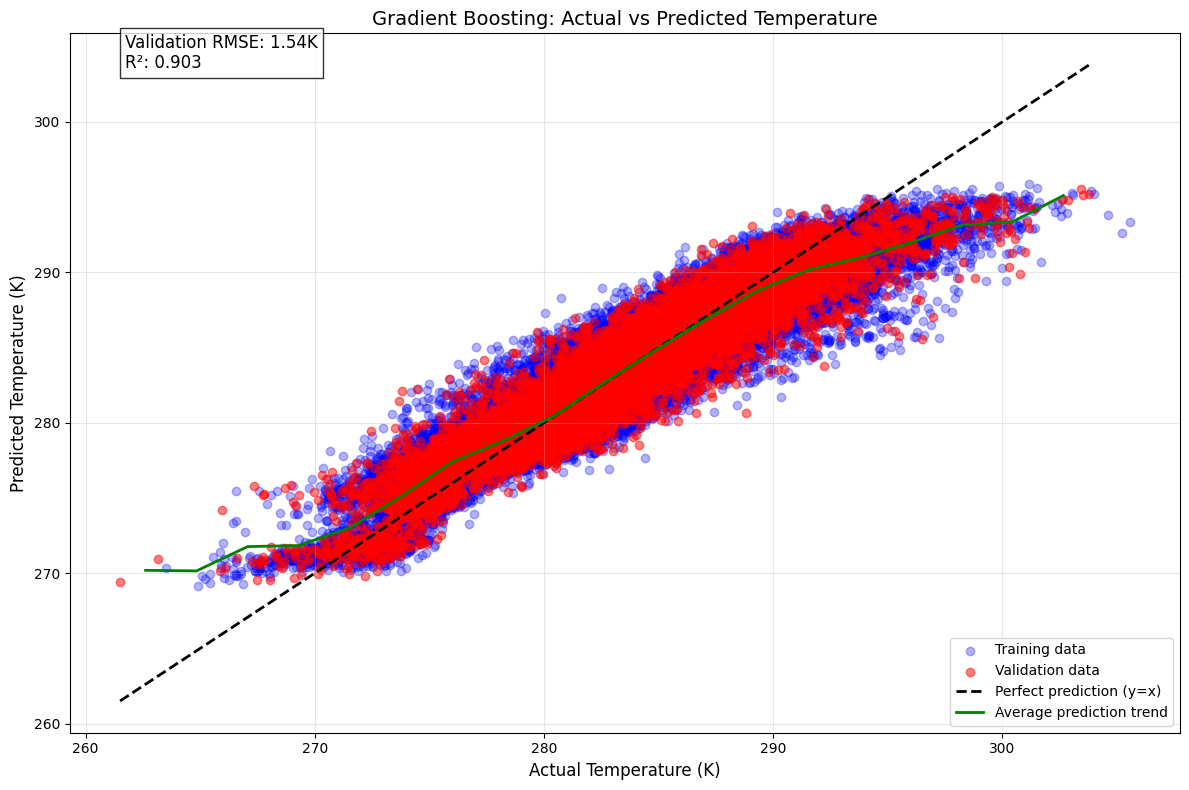

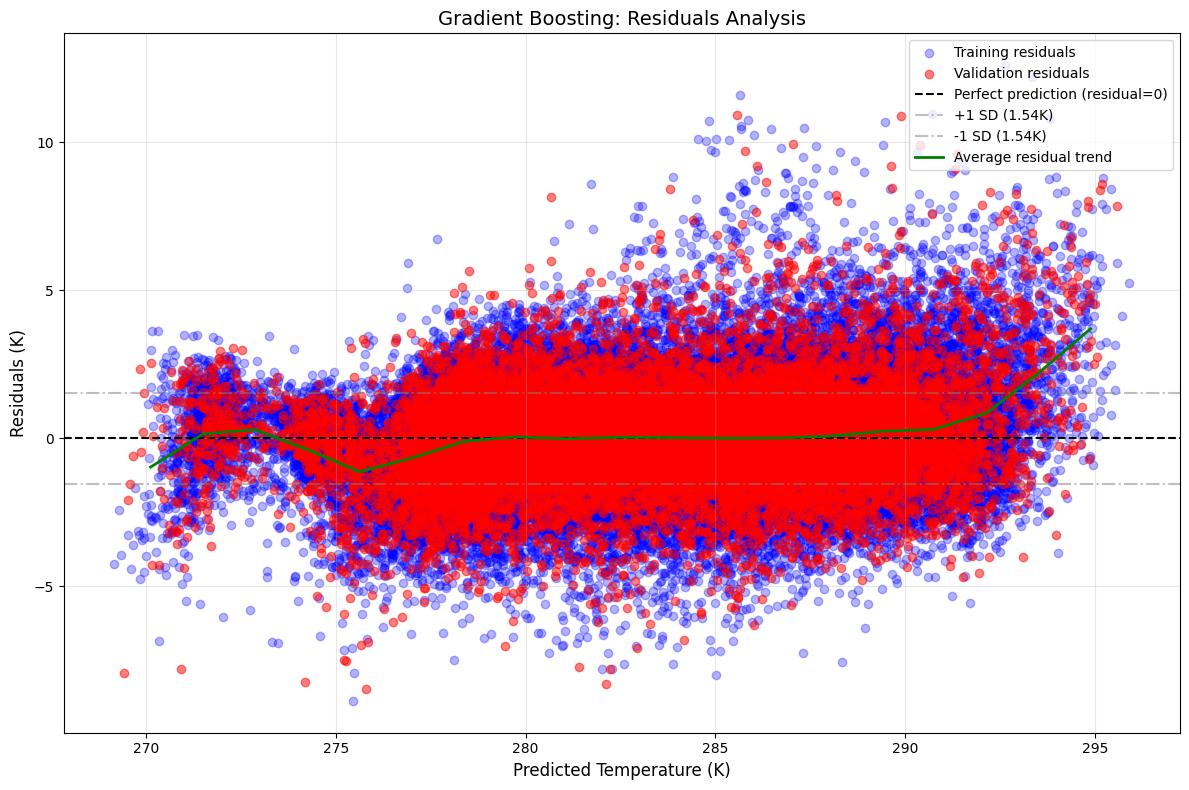

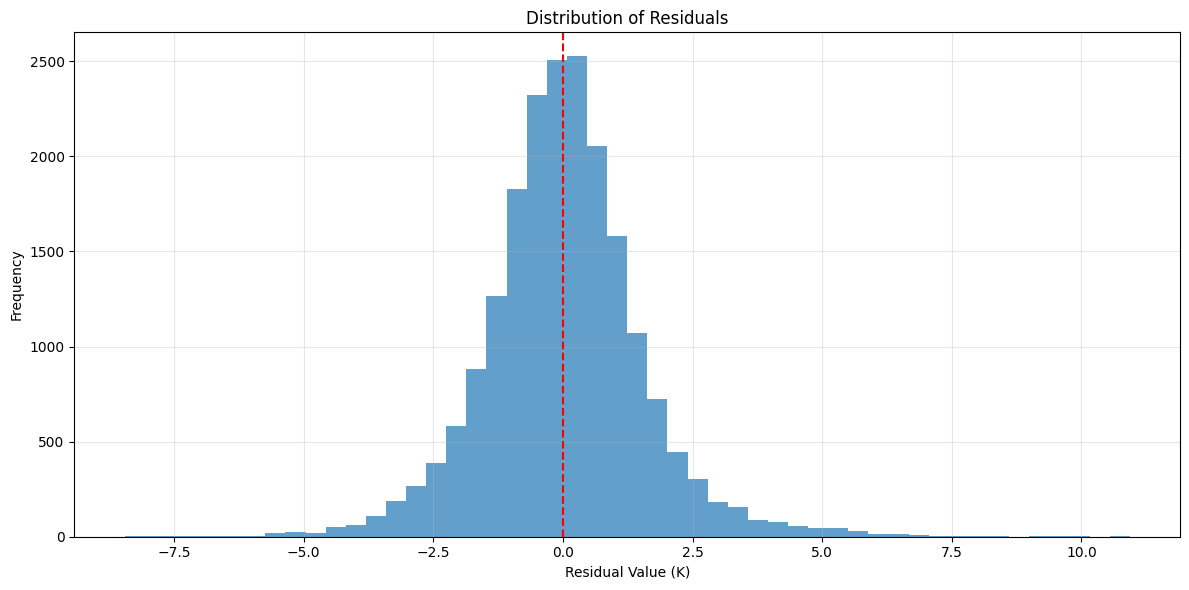

In [11]:
# 1. Improved Actual vs Predicted plot
plt.figure(figsize=(12, 8))

# Add separate colors for training and validation
plt.scatter(y_train, y_train_pred, alpha=0.3, label='Training data', color='blue')
plt.scatter(y_val, y_val_pred, alpha=0.5, label='Validation data', color='red')

# Add perfect prediction line with label
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
         'k--', lw=2, label='Perfect prediction (y=x)')

# Add a smoothed trend line to show actual model behavior
from scipy.stats import binned_statistic
bins = np.linspace(y_val.min(), y_val.max(), 20)
bin_means, bin_edges, _ = binned_statistic(y_val, y_val_pred, statistic='mean', bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, bin_means, 'g-', lw=2, label='Average prediction trend')

# Add metrics to the plot
plt.text(0.05, 0.95, f"Validation RMSE: {val_rmse:.2f}K\nR²: {val_r2:.3f}", 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.8))

plt.xlabel('Actual Temperature (K)', fontsize=12)
plt.ylabel('Predicted Temperature (K)', fontsize=12)
plt.title('Gradient Boosting: Actual vs Predicted Temperature', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Improved Residuals Plot
plt.figure(figsize=(12, 8))

# Add separate colors for training and validation
plt.scatter(y_train_pred, y_train - y_train_pred, alpha=0.3, label='Training residuals', color='blue')
plt.scatter(y_val_pred, y_val - y_val_pred, alpha=0.5, label='Validation residuals', color='red')

# Add zero line
plt.axhline(y=0, color='k', linestyle='--', label='Perfect prediction (residual=0)')

# Add standard deviation bands
std_dev = np.std(y_val - y_val_pred)
plt.axhline(y=std_dev, color='gray', linestyle='-.', alpha=0.5, label=f'+1 SD ({std_dev:.2f}K)')
plt.axhline(y=-std_dev, color='gray', linestyle='-.', alpha=0.5, label=f'-1 SD ({std_dev:.2f}K)')

# Add a smoothed trend line for residuals
bins = np.linspace(y_val_pred.min(), y_val_pred.max(), 20)
bin_means, bin_edges, _ = binned_statistic(y_val_pred, y_val - y_val_pred, statistic='mean', bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(bin_centers, bin_means, 'g-', lw=2, label='Average residual trend')

plt.xlabel('Predicted Temperature (K)', fontsize=12)
plt.ylabel('Residuals (K)', fontsize=12)
plt.title('Gradient Boosting: Residuals Analysis', fontsize=14)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Histogram of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--')
plt.xlabel('Residual Value (K)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4.4 Feature Importance

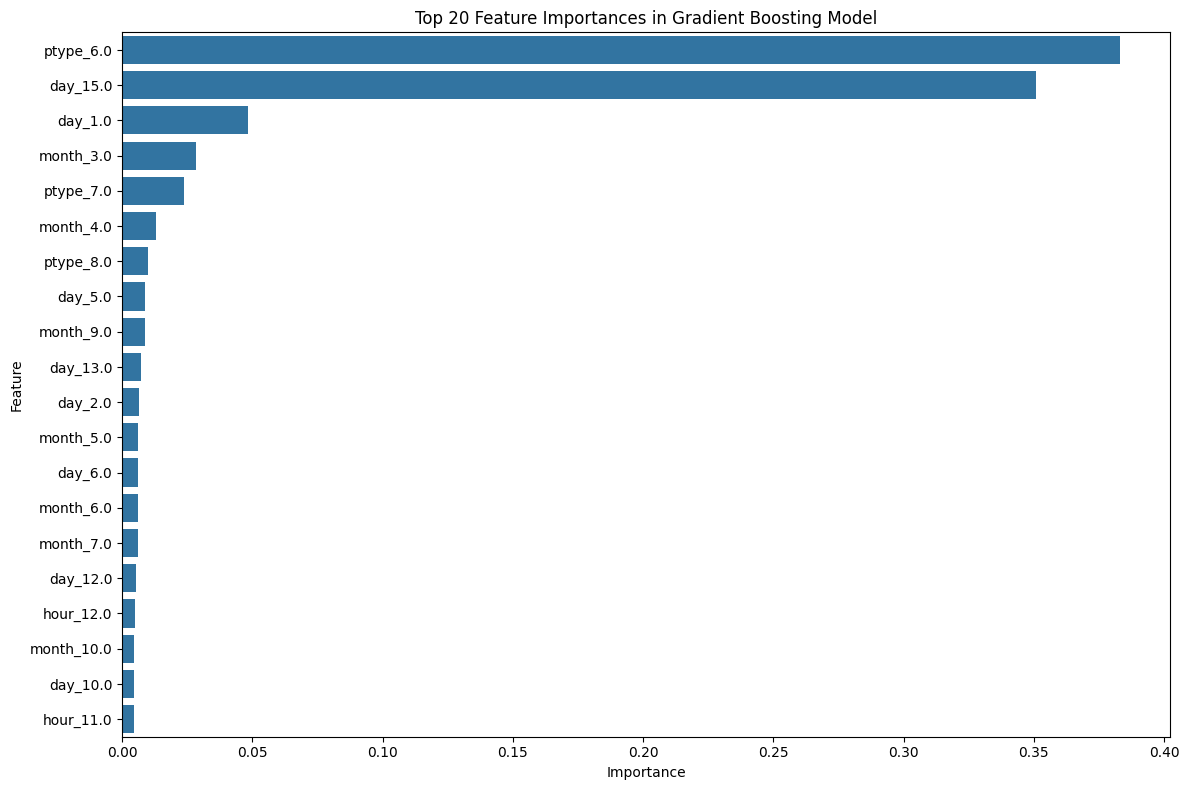

In [12]:
# Extract feature names after transformation
feature_names = []
cat_feature_names = []

try:
    cat_feature_names = list(gb_pipeline.named_steps['preprocessor']
                          .named_transformers_['cat-onehot']
                          .named_steps['onehot']
                          .get_feature_names_out(one_hot_attributes))
except:
    print("Warning: Could not extract categorical feature names - likely using older scikit-learn")
    # For older scikit-learn versions
    cat_feature_names = [f"{col}_{val}" for col in one_hot_attributes 
                       for val in range(10)]  # Approximate feature names

feature_names = numerical_attributes + list(cat_feature_names)

# Get feature importances
gb_model = gb_pipeline.named_steps['model']
feature_importances = gb_model.feature_importances_[:len(feature_names)]

# Map importances to feature names
importance_df = pd.DataFrame({
    'Feature': feature_names[:len(feature_importances)],
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 20 Feature Importances in Gradient Boosting Model')
plt.tight_layout()
plt.show()